# Figure 3: Significance of Correlation Statistic

**Alex B. Nielsen<sup>1,2</sup>, Alexander H. Nitz<sup>1,2</sup>, Collin Capano<sup>1,2</sup>, and Duncan A. Brown<sup>3</sup>**

 <sub>1. [Albert-Einstein-Institut, Max-Planck-Institut for Gravitationsphysik, D-30167 Hannover, Germany](http://www.aei.mpg.de/obs-rel-cos)</sub>  
 <sub>2. Leibniz Universitat Hannover, D-30167 Hannover, Germany</sub>  
 <sub>3. Department of Physics, Syracuse University, Syracuse, NY 13244, USA</sub>  

![Creative Commons License](https://i.creativecommons.org/l/by-sa/3.0/us/88x31.png "Creative Commons License")

This work is licensed under a [Creative Commons Attribution-ShareAlike 3.0 United States License](http://creativecommons.org/licenses/by-sa/3.0/us/).

We encourage use of these data in derivative works. If you use the material provided here, please cite [our paper.](https://arxiv.org/abs/1811.04071)

## Set up

Before running this notebook, you should run the [CreateResiduals](https://github.com/gwastro/gw150914_investigation/blob/master/CreateResiduals.ipynb) notebook to download the strain data and compute the maximum likelihood waveform.

In [2]:
import pycbc.noise.reproduceable as noise
from pycbc.filter import resample_to_delta_t
from pycbc.types import TimeSeries, zeros
import res
import numpy, os
import pylab
from scipy.stats import ks_2samp

The plots are written to the directory specified here. You can change the value of `output_dir` to the path where you want the plots to be written.

In [ ]:
output_dir = '../paper'
!mkdir -p {output_dir}

## Generate the background

*Note:* the following cells can take over 9 hours to run. If you would just like to plot the background saved on disk, skip down to the section "Figure 3" below.

In [ ]:
# Get the real strain
strain = res.get_residual_strain()

bsize = 100
bnum = 300

# Note: the following loop will take ~30mins

# Generate Fake Strain
fake_strain = {}
for i, ifo in enumerate(res.ifos):
    psd = strain[ifo].psd(32)
    ts = TimeSeries(zeros(16384 * bsize * bnum, dtype=numpy.float64), delta_t=1.0/16384)
    for j in range(bnum):
        s = j * bsize
        e = (j+1) * bsize
        print j, s, e
        tpart = ts.time_slice(s, e)      
        tpart[:] = noise.colored_noise(psd, s, e, seed=i, low_frequency_cutoff=15.0)
    fake_strain[ifo] = resample_to_delta_t(ts, 1.0/4096)

In [ ]:
real_bandpass = res.bandpass(strain)
fake_bandpass = res.bandpass(fake_strain)

In [ ]:
# Note: the following loop takes ~9 hours to run
dist_breal = []
dist_bfake = []

for dist, w in zip([dist_breal, dist_bfake],
                   [real_bandpass, fake_bandpass]):
    step = 0.061
    max_samples = int((w[ifo].end_time - w[ifo].start_time - 80) / step)
    print max_samples
    # This loop steps ``time`` through the real/fake data stream in strides of ``step``. On
    # each iteration, it calculates the cross correlation in the default window size of
    # time + 40ms, then finds the peak within +/-0.5ms of the 7ms offset between detectors.
    # Since the stride is 61ms and the window is 40ms, this ensures that each loop uses data
    # that is independent of the previous loop.
    for i in range(max_samples):
        time = w[ifo].start_time + 40 + i * step
                
            
        peak = res.get_peak(w, time)
        dist.append(peak)
        
        if i % 10 ==0:
            print time, i, peak

In [ ]:
numpy.savetxt('bkg_real.txt', dist_breal)
numpy.savetxt('bkg_simulated.txt', dist_bfake)

## Figure 3

Cumulative distribution of correlations in simulated colored Gaussian noise and detector data away from GW150914, using the same bandpass and notching, and correlation time window settings as used to produce Fig. 2. The minimum correlation values near the time of flight difference in Fig. 2 are plotted as vertical lines for reference.

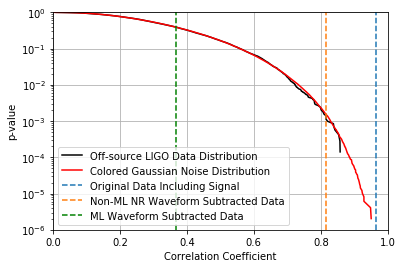

Ks_2sampResult(statistic=0.006222200206579154, pvalue=0.9492167825491061)


In [3]:
dist_breal = numpy.loadtxt('bkg_real.txt')
dist_bfake = numpy.loadtxt('bkg_simulated.txt')

for dist, label, color, in zip([dist_breal, dist_bfake], ['Off-source LIGO Data Distribution', 'Colored Gaussian Noise Distribution'], ['black', 'red']):
    dist = numpy.array(dist)
    dist.sort()
    x = numpy.arange(len(dist), 0, -1)
    pylab.plot(dist, x / float(len(x)), label=label, color=color)
    
# Taken from Fig 2. 
pylab.axvline(0.965, label='Original Data Including Signal', color='tab:blue', linestyle='--')
pylab.axvline(0.816, label='Non-ML NR Waveform Subtracted Data', color='tab:orange', linestyle='--')
pylab.axvline(0.369, label='ML Waveform Subtracted Data', color='green', linestyle='--')

pylab.xlim(0, 1)
pylab.ylim(1e-6, 1e0)
pylab.legend()
pylab.yscale('log')
pylab.ylabel('p-value')
pylab.grid()
pylab.xlabel('Correlation Coefficient')
pylab.savefig(os.path.join(output_path,'fig3.pdf'))
pylab.show()

from scipy.stats import ks_2samp
print ks_2samp(dist_breal, dist_bfake)